In [23]:
import cv2
import os
import matplotlib.pyplot as plt

In [24]:
file_names = list(os.listdir('gt'))[1:]

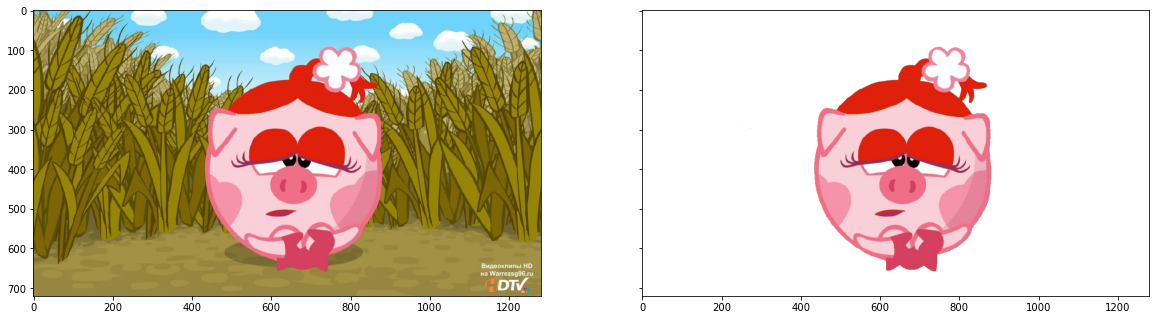

In [319]:
idx = 5

gt_example = cv2.imread("gt/{}".format(file_names[idx]), cv2.IMREAD_UNCHANGED)
target_example = cv2.imread("target/{}".format(file_names[idx], cv2.IMREAD_UNCHANGED))

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 20))
f.size = 100

ax1.imshow(cv2.cvtColor(target_example, cv2.COLOR_RGBA2BGR))
ax2.imshow(cv2.cvtColor(gt_example, cv2.COLOR_RGBA2BGR))

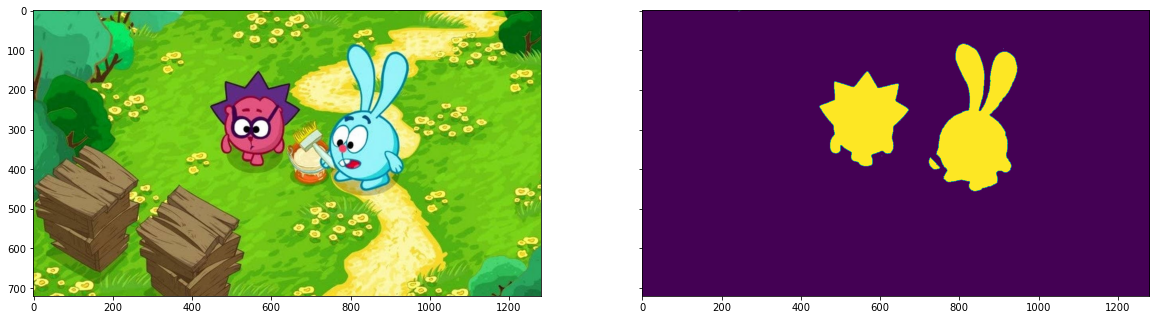

In [26]:
matting_mask = gt_example[:,:,3] > 0

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 20))
f.size = 100

ax1.imshow(cv2.cvtColor(target_example, cv2.COLOR_RGBA2BGR))
ax2.imshow(matting_mask)

In [27]:
import torchvision
torchvision.__version__

'0.11.3'

In [110]:
from torchsummary import summary

In [111]:
import segmentation_models_pytorch as smp
import torch
import numpy as np

In [177]:
model = smp.Unet('mobilenet_v2', in_channels=3, activation='sigmoid')
# summary(model, input_size = (3, 512, 512))

In [313]:
from torch.utils.data import Dataset, DataLoader

class SmeshMattingDataset(Dataset):
    """Smeshariki matting dataset."""

    def __init__(self, file_list, gt_dir, target_dir, transform=None):
        self.file_list = file_list
        self.gt_dir = gt_dir
        self.target_dir = target_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        gt = cv2.imread("gt/{}".format(file_names[idx]), cv2.IMREAD_UNCHANGED)
        image = cv2.imread("target/{}".format(file_names[idx]))
        gt = cv2.resize(gt, (512, 512) , interpolation = cv2.INTER_AREA)
        image = cv2.resize(image, (512, 512) , interpolation = cv2.INTER_AREA)
        mask = gt[:,:,3] > 0
        mask = mask > 0
        mask = mask.astype('uint8')
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            
            
        return torch.Tensor(image),  torch.Tensor(mask)

In [314]:
import albumentations as A

train_transform = A.Compose(
    [
        A.augmentations.geometric.rotate.Rotate(),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

In [315]:
train_dataset = SmeshMattingDataset(file_names, './gt', './target', train_transform)
train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
print(f'Train dataset has {len(train_data_loader)} batches of size {1}')

Train dataset has 11 batches of size 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


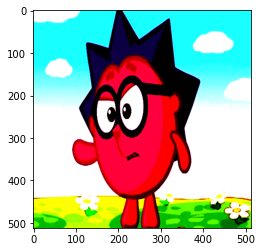

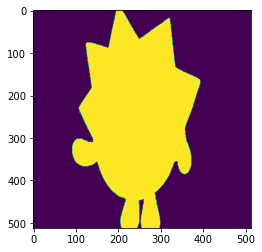

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


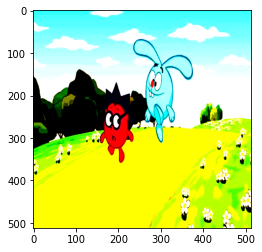

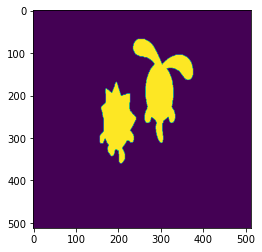

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


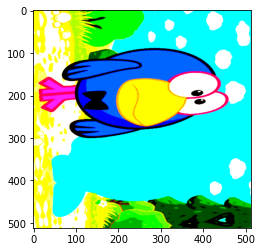

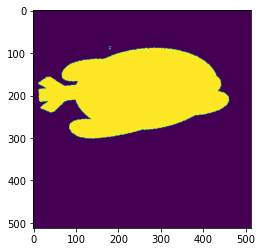

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


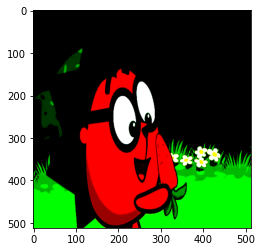

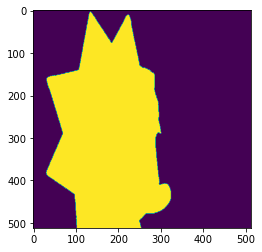

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


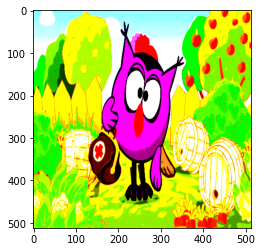

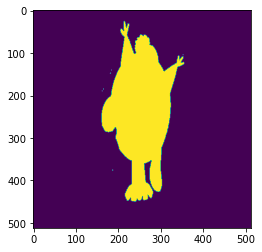

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


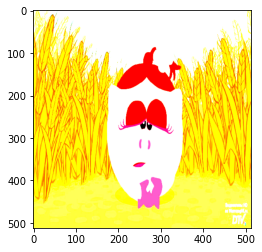

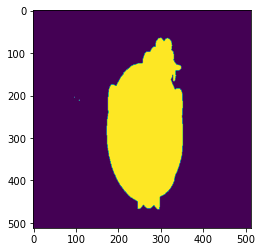

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


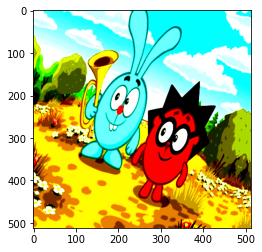

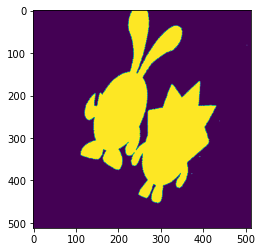

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


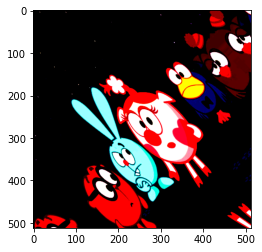

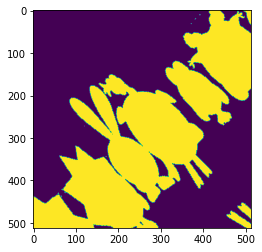

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


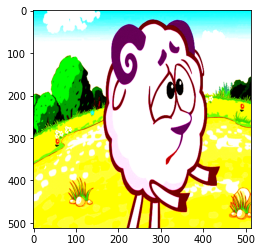

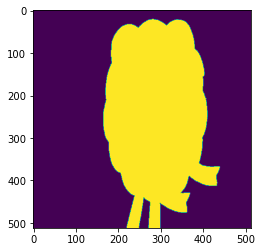

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


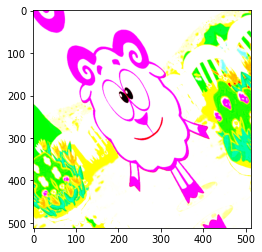

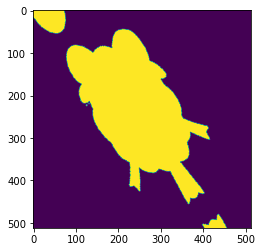

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


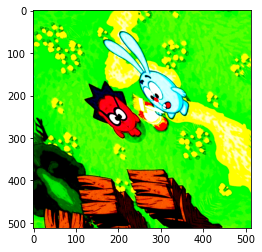

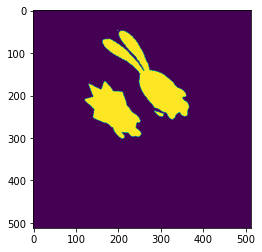

In [316]:
for i in train_data_loader:
    plt.imshow(cv2.cvtColor(i[0][0,:,:,:].detach().numpy(),cv2.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(i[1][0,:,:])
    plt.show()

In [317]:
device = torch.device('cpu')

15 epochs, 11 total_steps per epoch


11it [00:39,  3.56s/it]


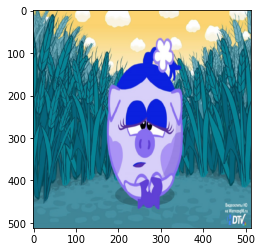

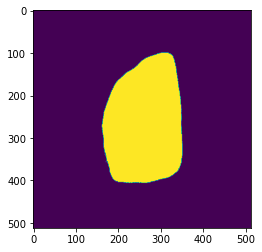

11it [00:39,  3.58s/it]


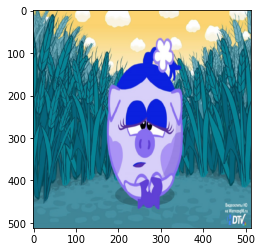

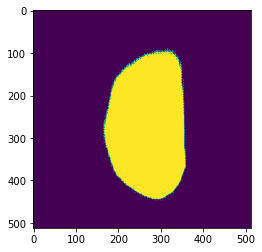

11it [00:39,  3.56s/it]


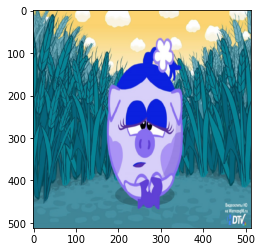

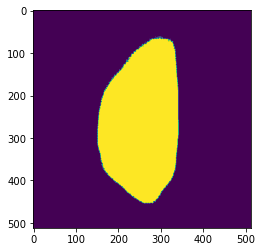

11it [00:39,  3.58s/it]


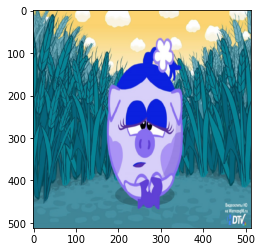

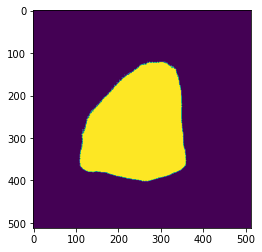

11it [00:39,  3.57s/it]


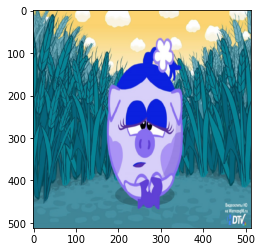

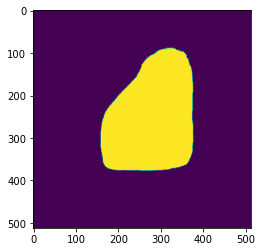

11it [00:39,  3.57s/it]


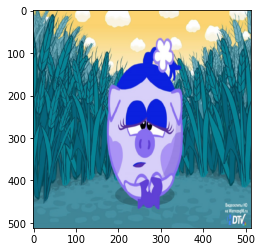

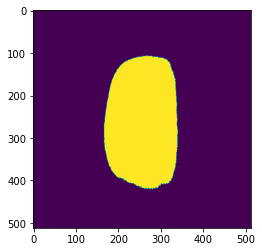

11it [00:39,  3.56s/it]


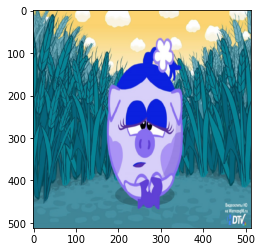

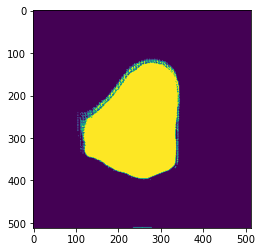

10it [00:36,  3.69s/it]


KeyboardInterrupt: 

In [320]:
import torch.nn.functional as F
from tqdm import tqdm

epochs = 15

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
fig, ax = plt.subplots()

total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

for epoch in range(epochs):
    for i, (images, masks) in tqdm(enumerate(train_data_loader, 1)):
        images = images.reshape(images.shape[0], images.shape[3], images.shape[1], images.shape[2])
        masks = masks.reshape(masks.shape[0], 1, masks.shape[1], masks.shape[2])
        # images = images.to(device)
        # masks = masks.type(torch.LongTensor)
        # res = masks.detach().numpy()[0,:,:]
        # plt.imshow(res)
        # plt.show()
        # masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        # print("loss:", loss)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i) % 100 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{total_steps}], Loss: {loss.item():4f}")
     
    
    ex = cv2.resize(target_example, (512, 512) , interpolation = cv2.INTER_AREA)
    plt.imshow(ex)
    plt.show()
    ex = torch.Tensor(ex)
    res = model(ex.reshape(1, ex.shape[2], ex.shape[0], ex.shape[1]))
    res = res.detach().numpy()[0,0,:,:]
    plt.imshow(res > 0.5)
    plt.show()
    

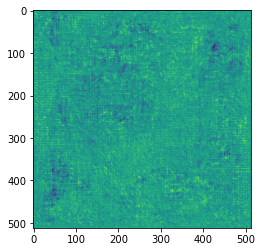

In [147]:
ex = cv2.resize(target_example, (512, 512) , interpolation = cv2.INTER_AREA)
ex = torch.Tensor(ex)
res = model(ex.reshape(1, ex.shape[2], ex.shape[0], ex.shape[1]))

res = res.detach().numpy()[0,0,:,:]
plt.imshow(res)